# Prototyping Trading Strategies with Python

Notebook for the "**Prototyping Trading Strategies with Python**" webinar done for futures.io.

&copy; Ran Aroussi | [@aroussi](http://twitter.com/aroussi) | [aroussi.com](http://aroussi.com) | [github.com/ranaroussi](https://github.com/ranaroussi)

---

## Recommended Reading list

### Python/Data Science Books
- [Python for Data Analysis](http://amzn.to/2lKNEyl) - Wes McKinney
- [Python for Finance](http://amzn.to/2lAJt68) - Yves Hilpisch 
- [Mastering Python for Finance](http://amzn.to/2lKNUNP) - James Ma Weiming
- [Web Scraping with Python](http://amzn.to/2lAJFlS) - Ryan Mitchell
- [Intro to Social Data for Traders](http://amzn.to/2mcYRcb) - MKTSTK

### Trading Books
- [Algorithmic Trading & DMA](http://amzn.to/2lAQofL) - Barry Johnson
- [Systematic Trading](http://amzn.to/2mcP6ue) - Robert Carver
- [Quantitative Trading: How to Build Your Own Algorithmic Trading Business](http://amzn.to/2lAFXbJ) - Ernest P. Chan
- [Algorithmic Trading: Winning Strategies and Their Rationale](http://amzn.to/2leAbLY) - Ernest P. Chan

In [1]:
%matplotlib inline

# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

# set defauly plotting size
import matplotlib.pylab
matplotlib.pylab.rcParams['figure.figsize'] = (12, 7)

# helper function for candlestick plotting
import matplotlib.dates as mdates
try:
    from mpl_finance import candlestick_ohlc
except ImportError:
    from matplotlib.finance import candlestick_ohlc

def plot_candlestick(df, ax=None, fmt="%Y-%m-%d", cols=["open", "high", "low", "close"]):
    if ax is None:
        fig, ax = plt.subplots()
        
    idx_name = df.index.name
    dat = df.reset_index()[[idx_name]+cols]
    dat[df.index.name] = dat[df.index.name].map(mdates.date2num)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter(fmt))
    plt.xticks(rotation=45)
    _ = candlestick_ohlc(ax, dat.values, width=.6, colorup='g', alpha =1)
    ax.set_xlabel(idx_name)
    ax.set_ylabel("Price")
    return ax

## Import SPY data using Pandas's DataReader

- Pandas is a library for data exploration and manipulation
- Main objects are `DataFrame` and `Series`
- Has many available built-in operations

In [2]:
import fix_yahoo_finance as yf

spy = yf.get_data_yahoo("SPY", start="2000-01-01")
spy.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,148.250000,148.250000,143.875000,145.4375,8164300,105.825332
2000-01-04,143.531204,144.062500,139.640594,139.7500,8089800,101.686912
2000-01-05,139.937500,141.531204,137.250000,140.0000,12177900,101.868820
2000-01-06,139.625000,141.500000,137.750000,137.7500,6227200,100.231643
2000-01-07,140.312500,145.750000,140.062500,145.7500,8066500,106.052718


### Adjust all columns using close/adj.close ratio

In [3]:
ratio = spy["Close"] / spy["Adj Close"]

spy["close"]  = spy["Adj Close"]
spy["open"]   = spy["Open"] / ratio
spy["high"]   = spy["High"] / ratio
spy["low"]    = spy["Low"] / ratio
spy["volume"] = spy["Volume"]

spy = spy[['open','high','low','close','volume']]
spy.head()

,open,high,low,close,volume
Date,,,,,
2000-01-03,107.871804,107.871804,104.688403,105.825332,8164300
2000-01-04,104.438246,104.824835,101.607304,101.686912,8089800
2000-01-05,101.823343,102.982977,99.867825,101.868820,12177900
2000-01-06,101.595958,102.960272,100.231643,100.231643,6227200
2000-01-07,102.096206,106.052718,101.914297,106.052718,8066500


In [4]:
# saving data
spy.to_csv('~/Desktop/sp500_ohlc.csv')

In [5]:
# how many rows/columns do we have?
spy.shape

(4314, 5)

In [6]:
# calculate returns
spy['return'] = spy['close'].pct_change()
spy['return'].describe()

count    4313.000000
mean        0.000264
std         0.012460
min        -0.098448
25%        -0.005086
50%         0.000654
75%         0.005933
max         0.145198
Name: return, dtype: float64

In [7]:
# slicing
spy[5:10][["close", "return"]]

,close,return
Date,,
2000-01-10,106.416535,0.003431
2000-01-11,105.143175,-0.011966
2000-01-12,104.097201,-0.009948
2000-01-13,105.506992,0.013543
2000-01-14,106.939489,0.013577


In [8]:
# slicing using queries
spy[ spy['return'] > 0.005 ]['return'].describe()

count    1244.000000
mean        0.012878
std         0.009962
min         0.005002
25%         0.006912
50%         0.010097
75%         0.014883
max         0.145198
Name: return, dtype: float64

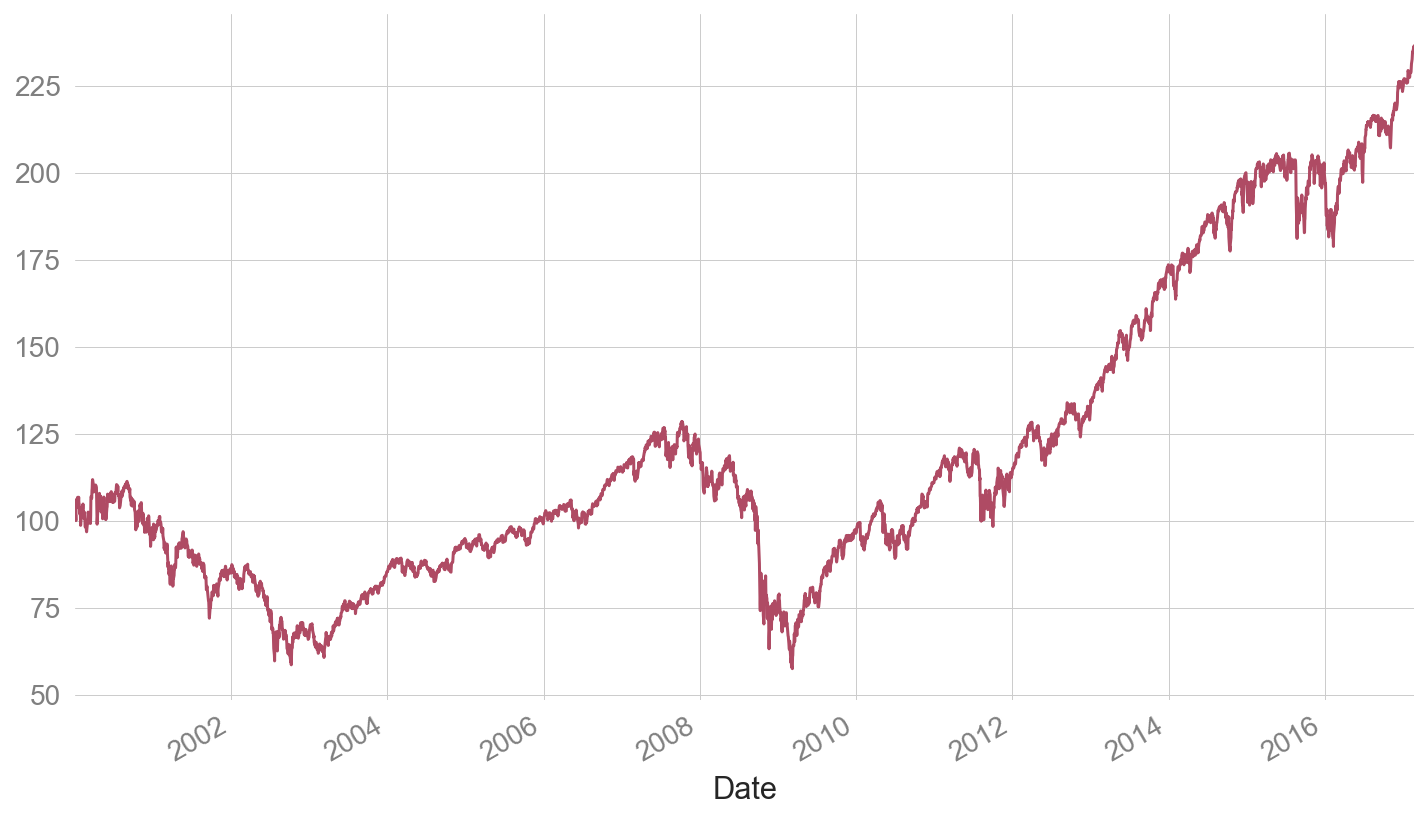

In [9]:
# simple plotting
spy['close'].plot()

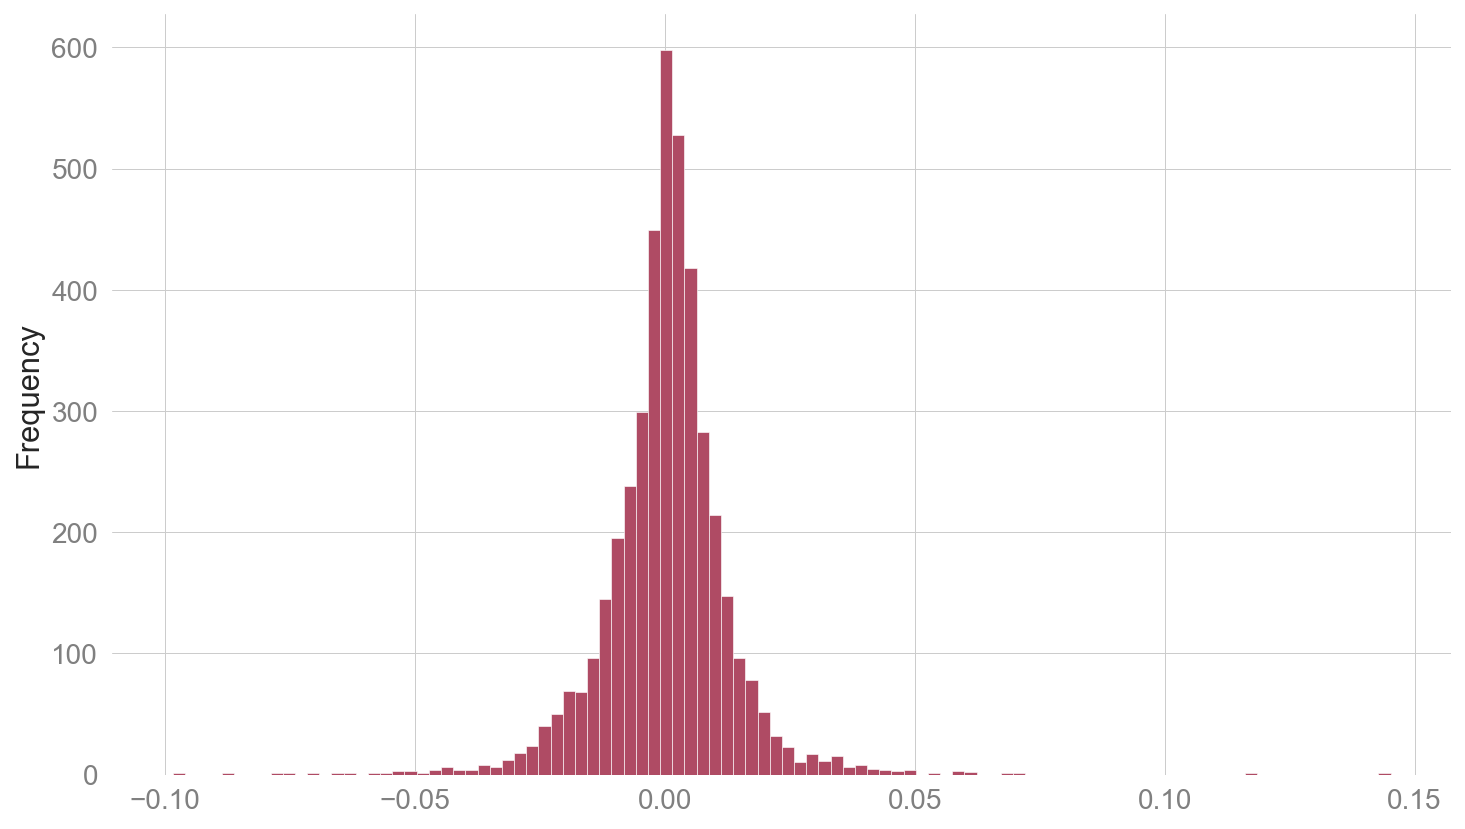

In [10]:
# histogram plot
spy['return'].plot.hist(bins=100, edgecolor='white')

In [11]:
# resampling to 1 year (A=Annual)
spy['return'].resample("1A").sum() * 100

Date
2000-12-31    -6.429918
2001-12-31   -10.111384
2002-12-31   -20.833354
2003-12-31    26.198963
2004-12-31    10.784570
2005-12-31     5.246394
2006-12-31    15.209572
2007-12-31     6.277696
2008-12-31   -37.358504
2009-12-31    26.929435
2010-12-31    15.631094
2011-12-31     4.527766
2012-12-31    15.638902
2013-12-31    28.622693
2014-12-31    13.265248
2015-12-31     2.414655
2016-12-31    12.184697
2017-12-31     5.769871
Freq: A-DEC, Name: return, dtype: float64

# Using Technical Indicators with Python

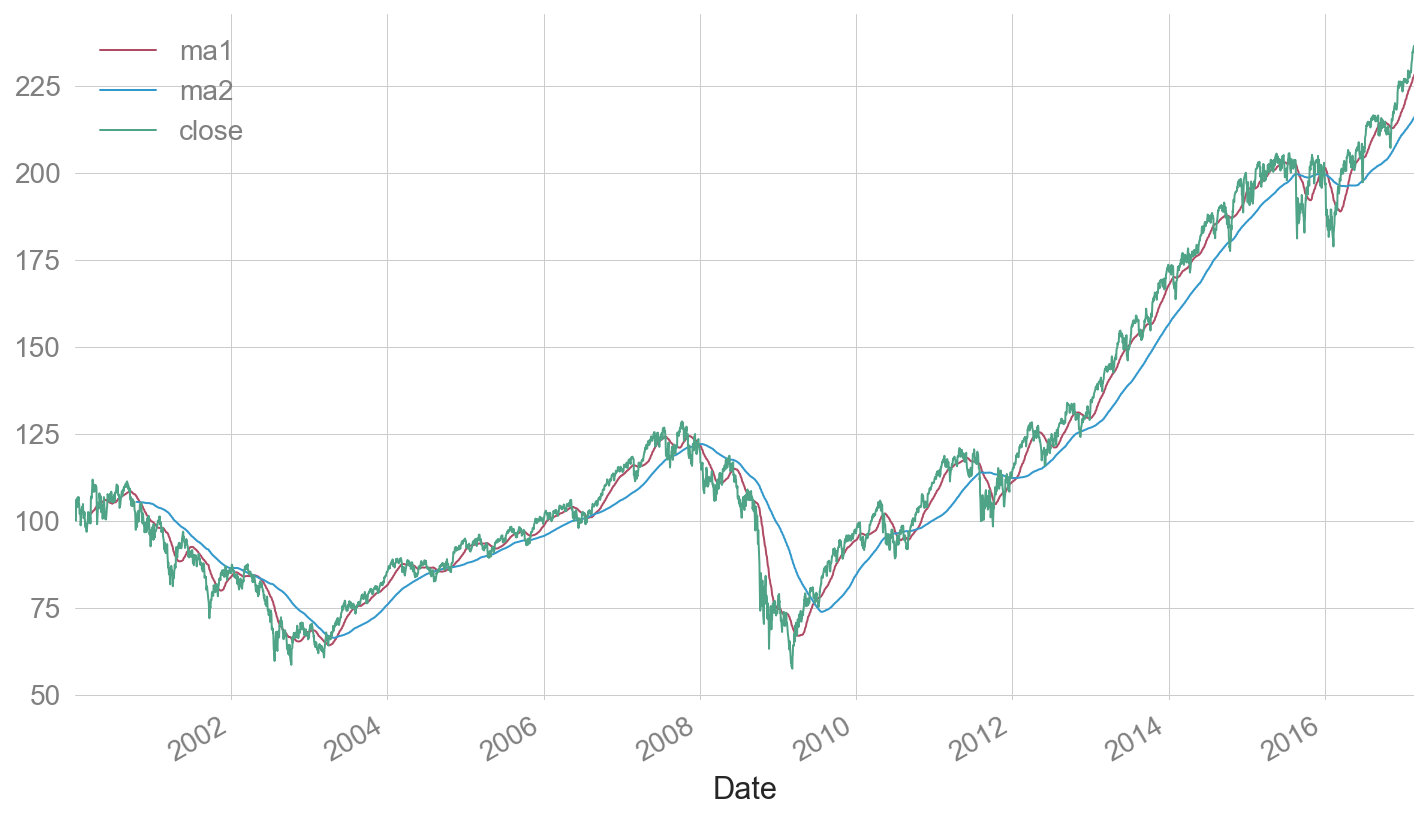

In [12]:
# using pandas' rolling mean
spy['ma1'] = spy['close'].rolling(window=50).mean()
spy['ma2'] = spy['close'].rolling(window=200).mean()

spy[['ma1', 'ma2', 'close']].plot(linewidth=1)

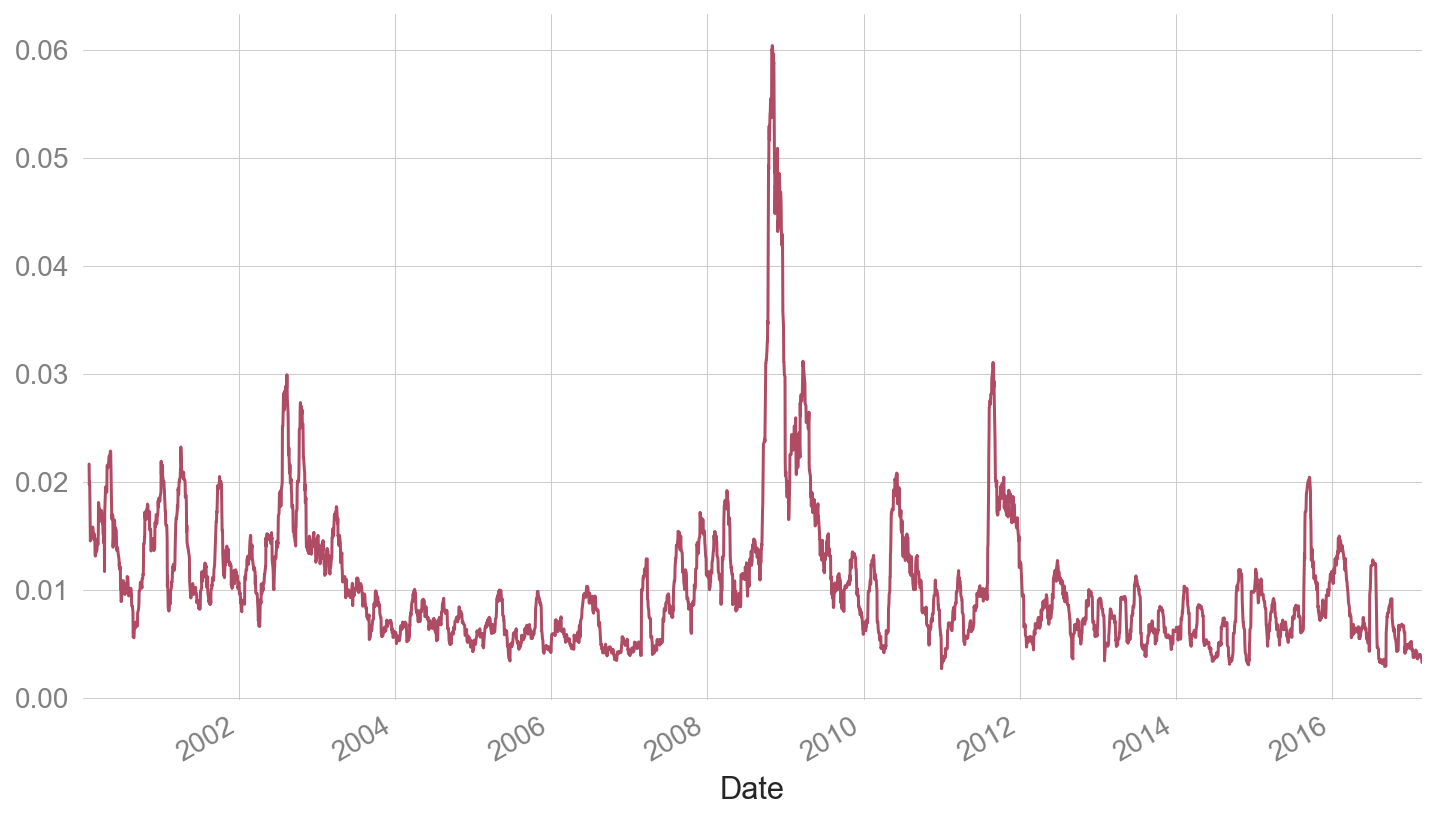

In [13]:
# rolling standard deviation
spy['return'].rolling(window=20).std().plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11db922e8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11db49f98>], dtype=object)

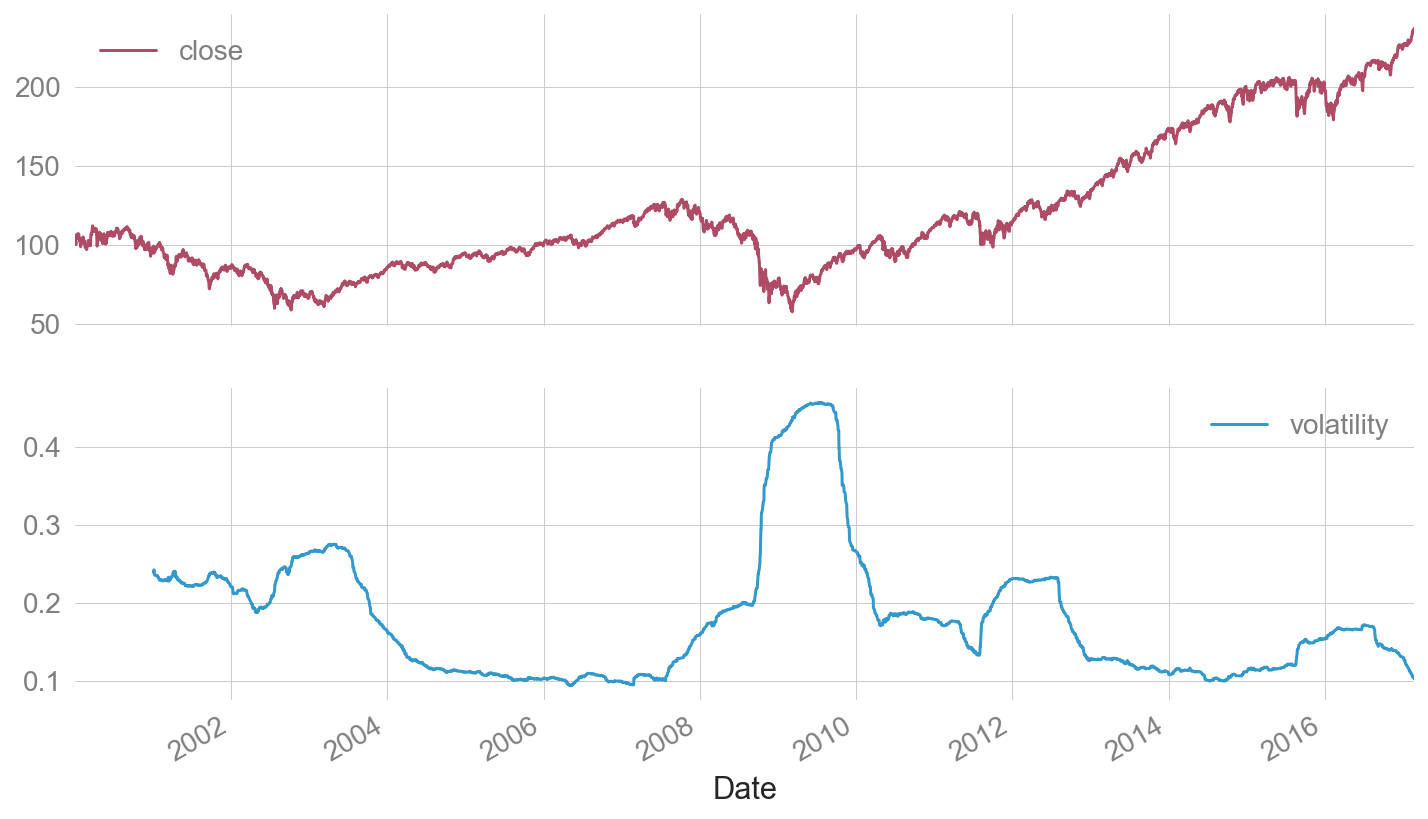

In [14]:
# calculating log returns and volatility
spy['logret'] = np.log(spy['close'] / spy['close'].shift(1))
spy['volatility'] = spy['logret'].rolling(window=252).std() * np.sqrt(252)

spy[['close', 'volatility']].plot(subplots=True)

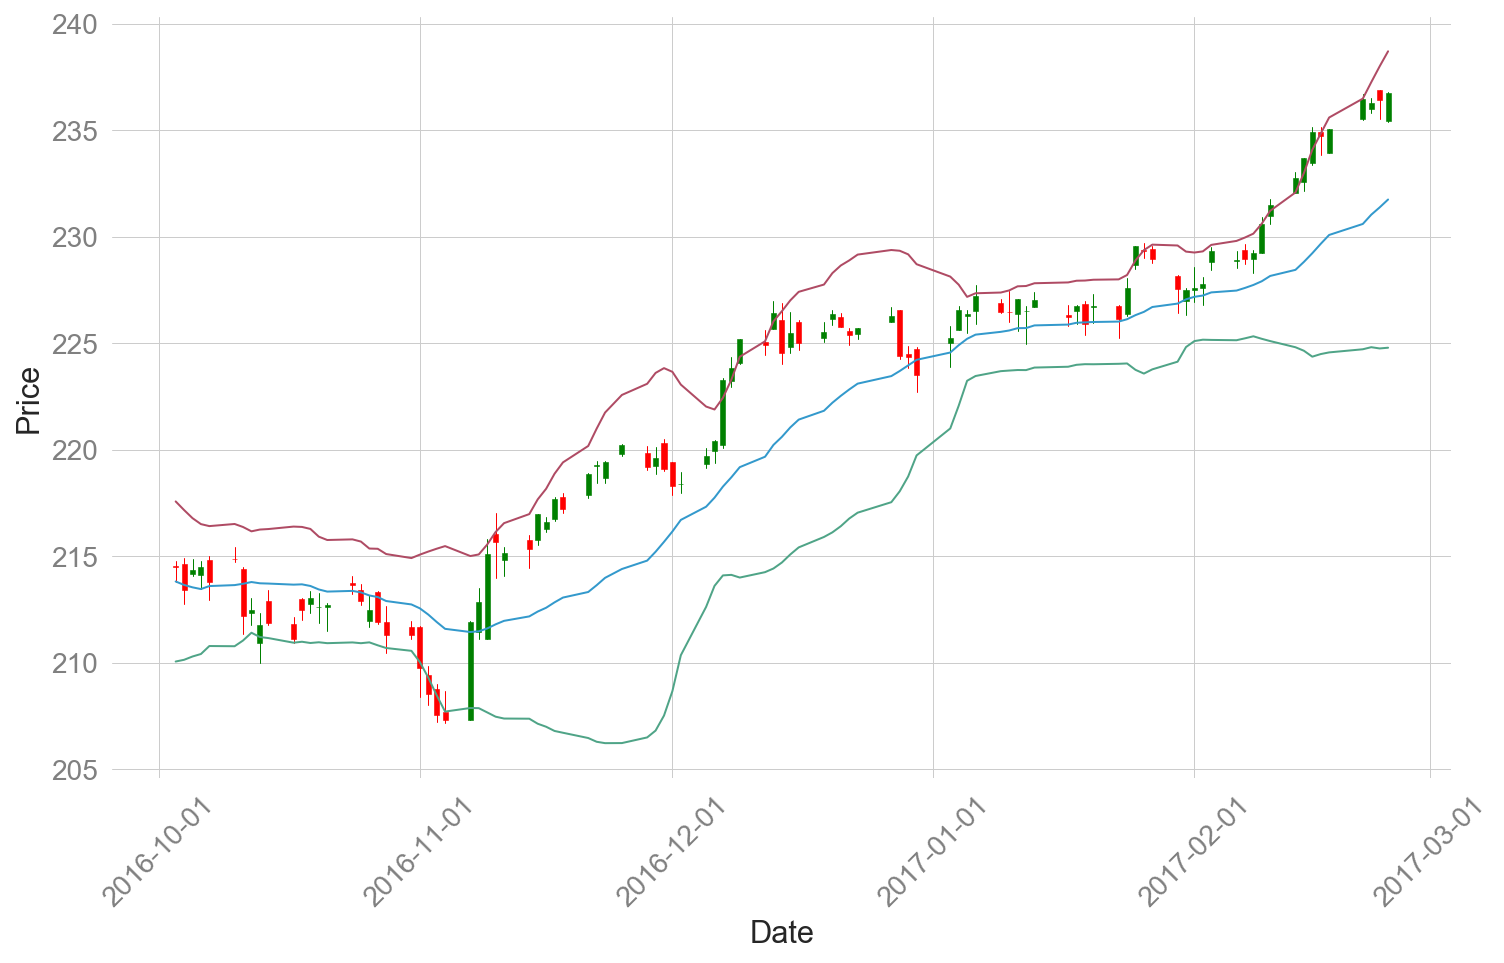

In [15]:
# pure python bollinger bands
spy['sma'] = spy['close'].rolling(window=20).mean()
spy['std'] = spy['close'].rolling(window=20).std()

spy['upperbb'] = spy['sma'] + (spy['std'] * 2)
spy['lowerbb'] = spy['sma'] - (spy['std'] * 2)

ax = plot_candlestick(spy[-100:])
ax.plot(spy[-100:][['upperbb', 'sma', 'lowerbb']], linewidth=1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11f412a58>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11f970e80>], dtype=object)

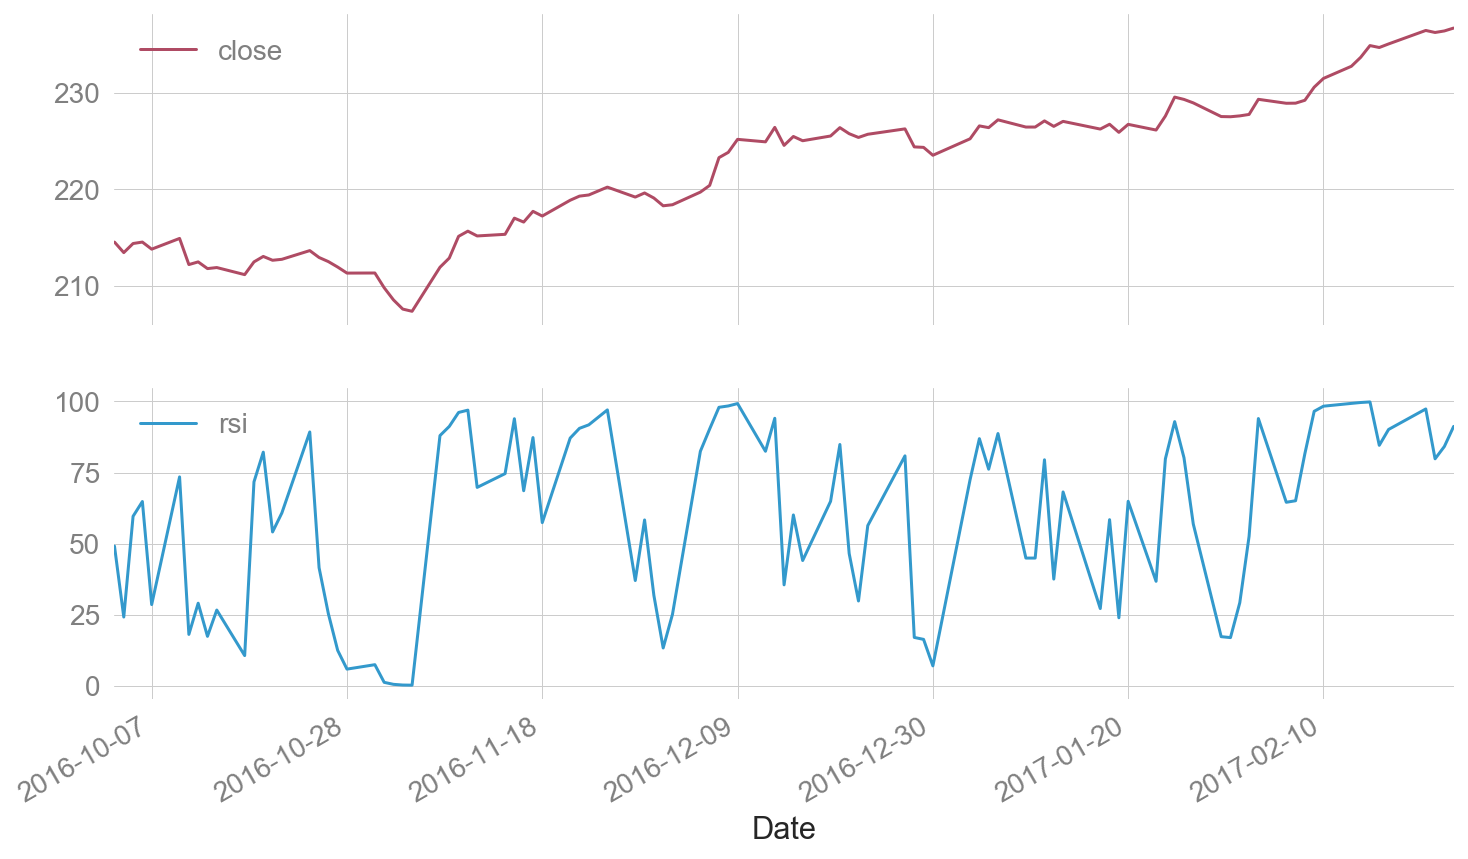

In [17]:
# using TA-Lib..
import talib as ta

spy['rsi'] = ta.RSI(spy['close'].values, timeperiod=2)
spy[-100:][['close', 'rsi']].plot(subplots=True)

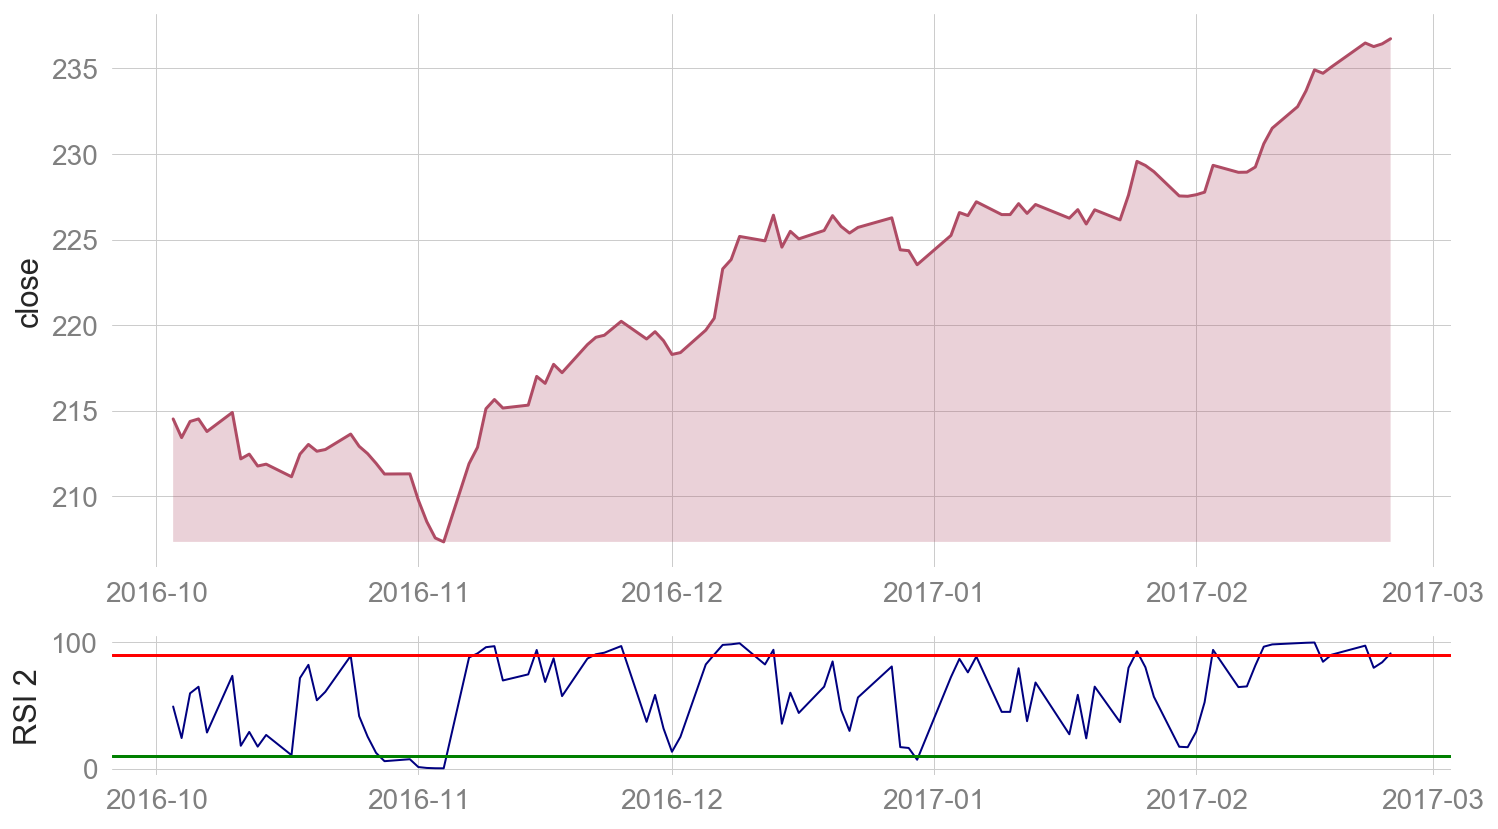

In [18]:
# having some fun with plotting :)

data = spy[-100:]

fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[4,1])

ax0 = plt.subplot(gs[0])
plt.plot(data['close'])
ax0.set_ylabel('close')
ax0.fill_between(data.index, data['close'].min(), data['close'], alpha=.25)

ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.set_ylabel('RSI 2')
ax1.plot(data['rsi'], color="navy", linewidth=1)
ax1.axhline(90, color='r', linewidth=1.5)
ax1.axhline(10, color='g', linewidth=1.5)

# Basic Strategy Example

- BUY ON CLOSE when SPY drops 0.5% (or more)
- SELL ON CLOSE of next day

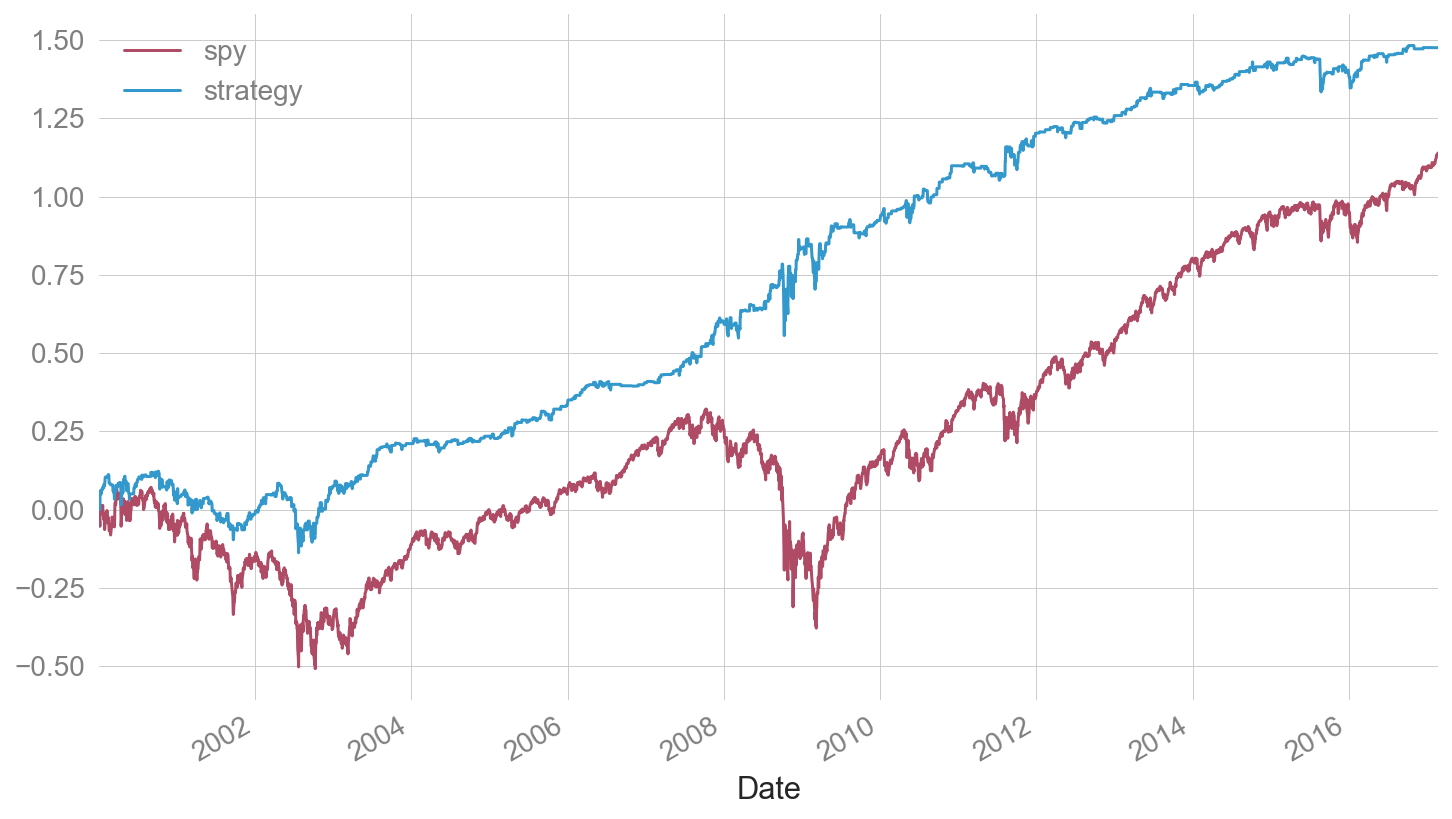

In [19]:
portfolio = pd.DataFrame(data={ 'spy': spy['return'] })
portfolio['strategy'] = portfolio[ portfolio['spy'].shift(1) <= -0.005 ]['spy']

# plot strategy
portfolio.fillna(0).cumsum().plot()

# Basic Performance Measuring

## Sharpe Ratio

Measures of risk adjusted return of investment (>1 is good, >2 is great)

#### Formula:

<big><code><br>Sharpe(X) = (rX - Rf) / StdDev(X)</code></big>

#### Where:

- `X` is the investment
- `rX` is the average rate of the return of `X`
- `Rf` is the best available risk-free security (i.e. T-bills)
- `StdDev(X)` is the standard deviation of `rX`

In [20]:
# Annualized Sharpe Ratio
def sharpe(returns, periods=252, riskfree=0):
    returns = returns.dropna()
    return np.sqrt(periods) * (np.mean(returns-riskfree)) / np.std(returns)

In [21]:
# benchmark sharpe
sharpe(portfolio['spy'])

0.33669274886838096

In [22]:
# strategy sharpe
sharpe(portfolio['strategy'])

1.3283765902862263

In [23]:
# time in market
len(portfolio['strategy'].dropna()) / len(portfolio)

0.2517385257301808

In [24]:
# EOY Returns
eoy = portfolio.resample("A").sum()
eoy['diff'] = eoy['strategy']/eoy['spy']

print( np.round(eoy[['spy', 'strategy', 'diff']] * 100, 2) )

              spy  strategy    diff
Date                               
2000-12-31  -6.43      3.69  -57.44
2001-12-31 -10.11     -5.20   51.39
2002-12-31 -20.83      9.04  -43.40
2003-12-31  26.20     13.54   51.69
2004-12-31  10.78      2.37   22.00
2005-12-31   5.25      9.82  187.18
2006-12-31  15.21      7.22   47.48
2007-12-31   6.28     19.61  312.41
2008-12-31 -37.36     23.44  -62.75
2009-12-31  26.93      8.87   32.96
2010-12-31  15.63     17.44  111.55
2011-12-31   4.53     10.44  230.57
2012-12-31  15.64      5.60   35.82
2013-12-31  28.62      9.61   33.58
2014-12-31  13.27      6.53   49.20
2015-12-31   2.41     -2.61 -108.18
2016-12-31  12.18      8.18   67.12
2017-12-31   5.77     -0.01   -0.15


# Enother Example

- GO LONG where 50-day SMA > 200-day SMA
- GO SHORT where 50-day SMA < 200-day SMA

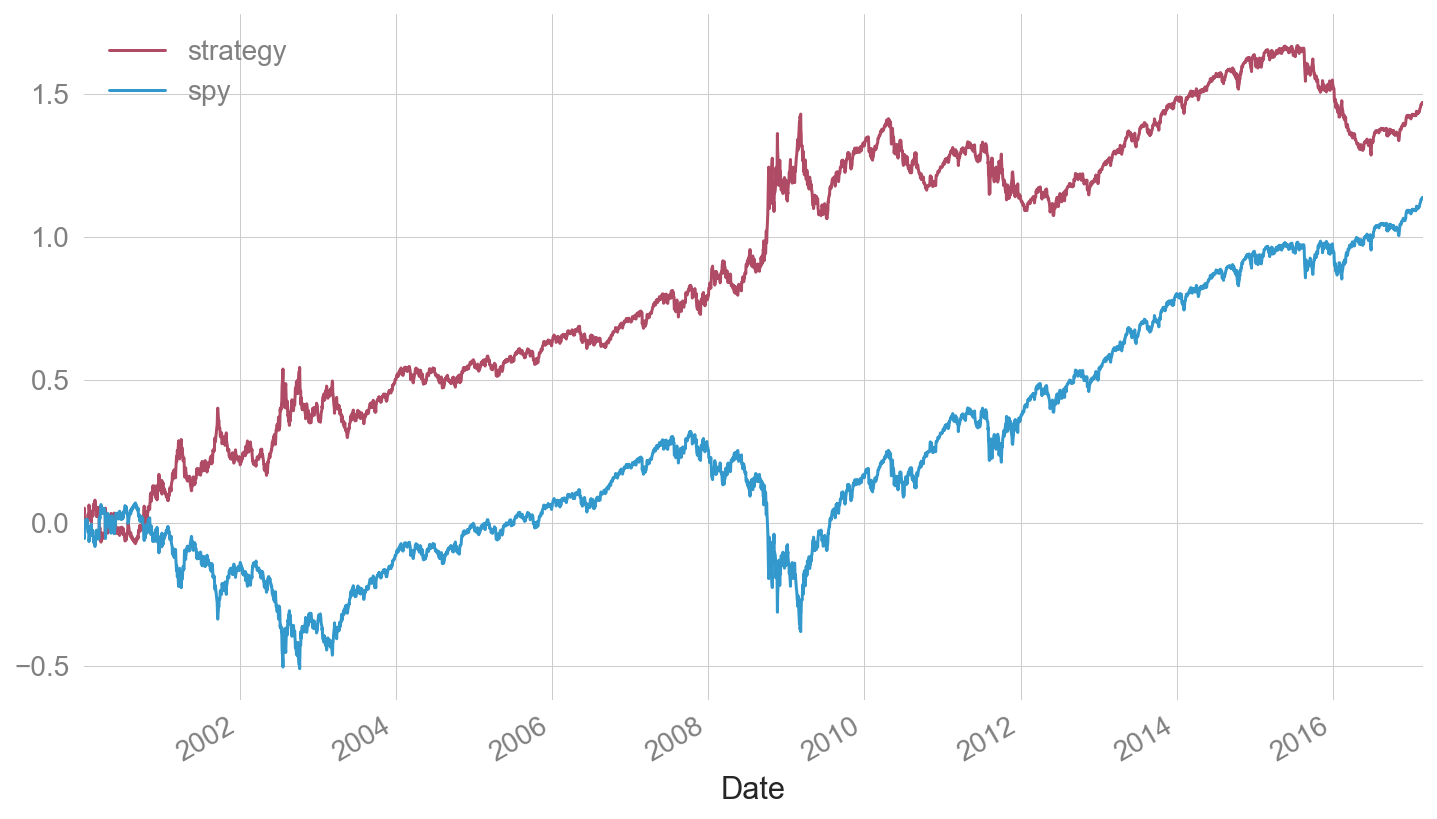

In [25]:
ma_portfolio = spy[['close', 'return']].copy()
ma_portfolio.rename(columns={'return':'spy'}, inplace=True)

# create the moving averages
ma_portfolio['ma1'] = ma_portfolio['close'].rolling(window=50).mean()
ma_portfolio['ma2'] = ma_portfolio['close'].rolling(window=200).mean()

# strategy rules
ma_portfolio['position'] = np.where(ma_portfolio['ma1'].shift(1) > ma_portfolio['ma2'].shift(1), 1, -1)
ma_portfolio['strategy'] = ma_portfolio['position'] * ma_portfolio['spy']

# plot
ma_portfolio[['strategy', 'spy']].cumsum().plot()

## Initial metrics

In [26]:
# benchmark sharpe
sharpe(ma_portfolio['spy'])

0.33669274886838096

In [27]:
# strategy sharpe
sharpe(ma_portfolio['strategy'])

0.43487255690177795

In [28]:
# time in market
len(ma_portfolio['strategy'].dropna()) / len(ma_portfolio)

0.9997681965693093

In [29]:
eoy = ma_portfolio.resample("A").sum()
eoy['diff'] = eoy['strategy']/eoy['spy']
print( np.round(eoy[['spy', 'strategy', 'diff']] * 100, 2) )

              spy  strategy    diff
Date                               
2000-12-31  -6.43     13.20 -205.34
2001-12-31 -10.11     10.11 -100.00
2002-12-31 -20.83     17.73  -85.10
2003-12-31  26.20      9.20   35.13
2004-12-31  10.78      6.56   60.84
2005-12-31   5.25      5.25  100.00
2006-12-31  15.21      9.06   59.57
2007-12-31   6.28      7.76  123.58
2008-12-31 -37.36     37.36 -100.00
2009-12-31  26.93     15.67   58.19
2010-12-31  15.63     -7.32  -46.82
2011-12-31   4.53    -10.19 -225.06
2012-12-31  15.64      6.07   38.84
2013-12-31  28.62     28.62  100.00
2014-12-31  13.27     13.27  100.00
2015-12-31   2.41     -9.04 -374.21
2016-12-31  12.18    -11.91  -97.75
2017-12-31   5.77      5.77  100.00
